In [60]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
import ast
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
from wordcloud import WordCloud

import datetime as dt

Supplementary Packages needed : <br>
* SPARQLWrapper
* scikit-learn
* wordcloud

# **STEP 0: Data opening and preprocessing**

The data in the CMU Movie Summary Corpus contains a collection of 42,306 movie plot summaries and metadata at both the movie level (including box office revenues, genre and date of release) and character level (including gender and estimated age):

**Data:**
1. `plot_summaries.txt.gz` [29 M]: Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.
2. `corenlp_plot_summaries.tar.gz` [628 M, separate download]: to downlaod if considered useful... The plot summaries from above, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv).

**Metadata:**
1. `movie.metadata.tsv.gz` [3.4 M]: Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:
- Wikipedia movie ID
- Freebase movie ID
- Movie name
- Movie release date
- Movie box office revenue
- Movie runtime
- Movie languages (Freebase ID:name tuples)
- Movie countries (Freebase ID:name tuples)
- Movie genres (Freebase ID:name tuples)
2. `character.metadata.tsv.gz` [14 M]: Metadata for 450,669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:
- Wikipedia movie ID
- Freebase movie ID
- Movie release date
- Character name
- Actor date of birth
- Actor gender
- Actor height (in meters)
- Actor ethnicity (Freebase ID)
- Actor name
- Actor age at movie release
- Freebase character/actor map ID
- Freebase character ID
- Freebase actor ID

**Test data**:
1. `tvtropes.clusters.txt`: 72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.
2. `name.clusters.txt`: 970 unique character names used in at least two different movies, along with 2,666 instances of those types. The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.

## Data loading

In [61]:
data_folder = './MovieSummaries/'

#### `characters`

In [62]:
characters = pd.read_csv(data_folder + 'character.metadata.tsv', sep='\t', header=None)
characters.columns =['Wikipedia_movie_ID', 
                     'Freebase_movie_ID', 
                     'Movie_release_date', 
                     'Character_name', 
                     'Actor_birth', 
                     'Actor_Gender', 
                     'Actor Height', 
                     'Actor_Ethnicity', 
                     'Actor_Name', 
                     'Age_at_movie_release', 
                     'Freebase_character_actor_map_ID', 
                     'Freebase_character_ID', 
                     'Freebase_actor_ID']

#### `movies`

In [63]:
movies = pd.read_csv(data_folder + 'movie.metadata.tsv', sep='\t', header=None)
movies.columns =['Wikipedia_movie_ID', 
                 'Freebase_movie_ID', 
                 'Name',
                 'Release_date', 
                 'Box_office_revenue', 
                 'Runtime',
                 'Languages', 
                 'Countries', 
                 'Genres']

#### `plot_summaries`

In [64]:
plot_summaries = pd.read_csv(data_folder + 'plot_summaries.txt', sep='\t', header=None)
plot_summaries.columns =['Wikipedia_movie_ID', 'Summary']

#### `character_types`

In [65]:
character_types = pd.read_csv(data_folder + 'tvtropes.clusters.txt', sep='\t', header=None)
character_types.columns =['Type', 'Info']

#### `name_clusters`

In [66]:
name_clusters = pd.read_csv(data_folder + 'name.clusters.txt', sep='\t', header=None)
name_clusters.columns =['Character_name', 'Freebase_character_actor_map_ID']

## Dataframes pre-processing 

### About Nan values

Below we will observe that numerous columns contains some null values resulting in a lot of rows having one or more missing features. In order to keep a maximum information, we will not drop all rows having at least one null value in their features because the other respective features might still be useful individually depending on what information we want to analyse. In fact we can see in the example below that dropping these rows will result in big lost of information. However, the null values will be handled when working on particular features with subsets of the original dataframe.

In [67]:
len(movies)

81741

In [68]:
len(movies.dropna())

8243

Indeed we would lost almost 90% of the rows.

### `characters` 

Each row is a character paired to an actor in a single movie, columns correspond to features that describe the characters, the actor that embodies them and the movie in which they appear. To get a better understanding, note that a single character can be played by multiple actors (e.g. James Bond) and that a single actor can have multiple roles. 

In [69]:
characters.head(1)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_birth,Actor_Gender,Actor Height,Actor_Ethnicity,Actor_Name,Age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7


In [70]:
characters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Wikipedia_movie_ID               450669 non-null  int64  
 1   Freebase_movie_ID                450669 non-null  object 
 2   Movie_release_date               440674 non-null  object 
 3   Character_name                   192794 non-null  object 
 4   Actor_birth                      344524 non-null  object 
 5   Actor_Gender                     405060 non-null  object 
 6   Actor Height                     154824 non-null  float64
 7   Actor_Ethnicity                  106058 non-null  object 
 8   Actor_Name                       449441 non-null  object 
 9   Age_at_movie_release             292556 non-null  float64
 10  Freebase_character_actor_map_ID  450669 non-null  object 
 11  Freebase_character_ID            192804 non-null  object 
 12  Fr

Note that only the features `Wikipedia_movie_ID`, `Freebase_movie_ID` and `Freebase_character_actor_map_ID` do not contain missing values. <br>
In particular we can see below that only `Freebase_character_actor_map_ID` values are all unique, in fact this mapping ID is uniquely created for each single movie. <br>
Surprisingly the number of unique `Actor_Name` is greater than the number of unique `Character_name`. However the number of unique `Freebase_character_ID` is lower than the `Freebase_actor_ID`. The latter was expected since an actor can have multiple roles. <br>
Observe that the difference between the number of actor names (134'078) and the number of freebase actor ids (135'760, unique by definition) is different. Thus we can expect some actors to have the same name but to be different persons having a different id (observe in the second cell below that there are 1240 names of actor that are associated to 2 or more different freebase actor id.). The same is expected for characters but with more occurence. For example 'Bob' is more likely to be the name of multiple different characters than 'Roger Moore' is to be the name of multiple different actors.

In [71]:
characters.nunique()

Wikipedia_movie_ID                  64330
Freebase_movie_ID                   64330
Movie_release_date                  18476
Character_name                     126629
Actor_birth                         29494
Actor_Gender                            2
Actor Height                          221
Actor_Ethnicity                       479
Actor_Name                         134078
Age_at_movie_release                  155
Freebase_character_actor_map_ID    450669
Freebase_character_ID              183435
Freebase_actor_ID                  135760
dtype: int64

Below is a good example to understand the subtility of this dataframe. Each row contains the information of an actor that played a particular character in a particular movie. Thus, if an actor plays the same character that appears in n movies, there will be n rows to describe their relationships where not only the features related to the movie will change, but also their map id. This show the specificity of this feature that describe a unique triplet of [actor, character, movie].

In [72]:
characters.loc[characters.Actor_Name == 'Roger Moore'].query("Character_name == 'James Bond'")

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_birth,Actor_Gender,Actor Height,Actor_Ethnicity,Actor_Name,Age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
31341,6446062,/m/01kf3_9,1979-06-26,James Bond,1927-10-14,M,1.85,/m/02w7gg,Roger Moore,51.0,/m/02xg8wv,/m/0clpml,/m/017lqp
69068,6446044,/m/0g5pv3,1981-06-24,James Bond,1927-10-14,M,1.85,/m/02w7gg,Roger Moore,53.0,/m/02xg8x3,/m/0clpml,/m/017lqp
124179,583932,/m/02sg5v,1985-05-22,James Bond,1927-10-14,M,1.85,/m/02w7gg,Roger Moore,57.0,/m/02xg8xd,/m/0clpml,/m/017lqp
149343,6223567,/m/0fxmbn,1974-12-19,James Bond,1927-10-14,M,1.85,/m/02w7gg,Roger Moore,47.0,/m/02xg8w8,/m/0clpml,/m/017lqp
202846,6446061,/m/0g5pvv,1973-06-27,James Bond,1927-10-14,M,1.85,/m/02w7gg,Roger Moore,45.0,/m/02xg8v_,/m/0clpml,/m/017lqp
234294,541642,/m/02n72k,1983-06-06,James Bond,1927-10-14,M,1.85,/m/02w7gg,Roger Moore,55.0,/m/02k8g9d,/m/0clpml,/m/017lqp
425243,6446036,/m/0g5ptf,1977-07-07,James Bond,1927-10-14,M,1.85,/m/02w7gg,Roger Moore,49.0,/m/02xg8wk,/m/0clpml,/m/017lqp


Now that we have understood the structure of the `characters` dataframe, we would like to retrieve the wikidata items corresponding to the freebase IDs contained in `Actor_Ethnicity`, to add an extra feature to our dataframe. To do so we will use the wikidata query service through the sparqlwrapper package.

In [73]:
#print all freebase with format corresponding to the wikidata query service. Then manually copy pasted
ethnicity_id = list(characters['Actor_Ethnicity'].value_counts().index)
for e in ethnicity_id : print('"'+e+'"',end=' ')

"/m/0dryh9k" "/m/0x67" "/m/041rx" "/m/02w7gg" "/m/033tf_" "/m/0xnvg" "/m/02ctzb" "/m/07hwkr" "/m/07bch9" "/m/044038p" "/m/03bkbh" "/m/0d7wh" "/m/03ts0c" "/m/0222qb" "/m/01rv7x" "/m/02sch9" "/m/04mvp8" "/m/03lmx1" "/m/065b6q" "/m/01qhm_" "/m/06mvq" "/m/048z7l" "/m/0bpjh3" "/m/0cqgdq" "/m/0g8_vp" "/m/09vc4s" "/m/013xrm" "/m/019kn7" "/m/06gbnc" "/m/07mqps" "/m/01g7zj" "/m/01xhh5" "/m/03bx0k4" "/m/0g96wd" "/m/02g7sp" "/m/09m6hr" "/m/063k3h" "/m/0g0x7_" "/m/03ttfc" "/m/023mqw" "/m/0d2by" "/m/09kr66" "/m/042gtr" "/m/025rpb0" "/m/08hpk0" "/m/038723" "/m/0583cz" "/m/022dp5" "/m/0cmdl5l" "/m/03vv99" "/m/029f2r" "/m/09k5jvk" "/m/0cnvdq1" "/m/06v41q" "/m/04gfy7" "/m/0bymc" "/m/0cn68" "/m/09v5bdn" "/m/05l3g_" "/m/0268_k" "/m/0dqqwy" "/m/075_n6" "/m/0bbz66j" "/m/02rbdlq" "/m/0bkbz" "/m/01336l" "/m/04dbw3" "/m/0fqz6" "/m/06j2v" "/m/046cwm" "/m/0g6ff" "/m/0432mrk" "/m/0gkxl2" "/m/02p1pl6" "/m/03w9bjf" "/m/04tvpv" "/m/027n1m6" "/m/09743" "/m/0bhsnb" "/m/013b6_" "/m/048sp5" "/m/0h2138" "/m/02y_9mh" "/m

In [74]:
#https://rdflib.github.io/sparqlwrapper/

#Below the query is made in two steps to respect the maximal size of the function's capacity

endpoint_url = "https://query.wikidata.org/sparql"

query1 = """PREFIX wdt: <http://www.wikidata.org/prop/direct/>
SELECT DISTINCT ?id ?itemLabel WHERE {
  VALUES ?id {"/m/044038p" "/m/075_n6" "/m/0bbz66j" "/m/02rbdlq" "/m/0bkbz" "/m/01336l" "/m/04dbw3" "/m/0fqz6" "/m/06j2v" "/m/046cwm" "/m/0g6ff" "/m/0432mrk" "/m/0gkxl2" "/m/02p1pl6" "/m/03w9bjf" "/m/04tvpv" "/m/027n1m6" "/m/09743" "/m/0bhsnb" "/m/013b6_" "/m/048sp5" "/m/0h2138" "/m/02y_9mh" "/m/02jvpv" "/m/0dbxy" "/m/02vsw1" "/m/08cjt2" "/m/013s3n" "/m/09zyn5" "/m/0cm7w1" "/m/04q7gbh" "/m/0fj1k9" "/m/0fqp6zk" "/m/04f581" "/m/012c1l" "/m/071x0k" "/m/0ffjqy" "/m/0ffkb4" "/m/0g5y6" "/m/0bzkm2" "/m/0dllcfn" "/m/04y8_bm" "/m/03gskx0" "/m/0268d21" "/m/019lrz" "/m/02p4q5p" "/m/04czx7" "/m/02p656s" "/m/0ffhz3" "/m/04jq32s" "/m/04mmhj" "/m/0dj8k3" "/m/059_w" "/m/01kg2v" "/m/0222hg" "/m/0f0gt_" "/m/01j2qv" "/m/0ffjvd" "/m/032j30" "/m/033njm" "/m/0bs7l_v" "/m/0g48m4" "/m/022fdt" "/m/052r3t" "/m/0bfjm7" "/m/01xttr" "/m/04ydrsn" "/m/03295l" "/m/06lshc" "/m/03cbkrf" "/m/0283js_" "/m/09cqth" "/m/04nrnz" "/m/05748" "/m/025_0f0" "/m/01trsl" "/m/09vmyh" "/m/05sf2x" "/m/09gk_6h" "/m/078vc" "/m/01p7s6" "/m/017sq0" "/m/018s6c" "/m/04y29" "/m/067lts" "/m/05g0f1" "/m/0761bp" "/m/09gp4" "/m/02qv_h_" "/m/0640_7q" "/m/0912ll" "/m/013b7g" "/m/067lrj" "/m/0b79c7" "/m/09lz9zx" "/m/01swvz" "/m/01nbcy" "/m/0b0gzf" "/m/071drf" "/m/027vy0s" "/m/0150zs" "/m/0278pqj" "/m/0747611" "/m/0c2hxm" "/m/0462jl6" "/m/074w_m" "/m/04ggbzy" "/m/0hbz9xw" "/m/0152s7" "/m/0fng3k" "/m/0j4w_" "/m/0b98sy" "/m/08v2k7" "/m/0j6x8" "/m/0d9q7j" "/m/016f5d" "/m/0ffj5g" "/m/0338zd" "/m/04_tz7" "/m/027lf0d" "/m/0ch3pqf" "/m/06fczy" "/m/01mw1s" "/m/04608z" "/m/04_hr_" "/m/026cybk" "/m/01hwt" "/m/08gzsf" "/m/05vhv7" "/m/04_bc8" "/m/06rd7" "/m/0318mh" "/m/02wcbj_" "/m/0520604" "/m/07j80c" "/m/078ds" "/m/0fk1z" "/m/0dv5vw" "/m/04znbg" "/m/01sq7s" "/m/0gf5k1" "/m/03pqwy" "/m/031_sd" "/m/012f86" "/m/092h2qt" "/m/033qxt" "/m/03vghh" "/m/0bjbszh" "/m/07hyjp" "/m/03yk6g" "/m/0h1nk0k" "/m/04zjjt" "/m/02czfr" "/m/05qb937" "/m/047l_90" "/m/0bnzjx" "/m/02q206y" "/m/0665pp" "/m/07gzw5" "/m/062_25" "/m/0hj35" "/m/0bh91q8" "/m/01g0y_" "/m/07lv5x" "/m/0g4pffv" "/m/0828vj" "/m/07d_p8" "/m/04lhn7b" "/m/0fq6zlv" "/m/0268pvf" "/m/0466nw8" "/m/04pnf" "/m/02p_gby" "/m/06k6sl" "/m/0738n4" "/m/0266mf0" "/m/0cx3p" "/m/04kbvpz" "/m/07s9g04" "/m/04l_pt" "/m/026c9dq" "/m/01ylpf" "/m/0g5k7qv" "/m/01tyl3" "/m/0b__fv3" "/m/02vkd28" "/m/013s41" "/m/047948f" "/m/067lwk" "/m/03d19xz" "/m/02gx2x" "/m/021pd" "/m/013s2p" "/m/09fqz7" "/m/0ffhvl" "/m/075dhf0" "/m/02dd5z" "/m/03wbmrc" "/m/0br_8h" "/m/097nms" "/m/02cm28" "/m/0h6mqq9" "/m/09tqq8q" "/m/0301y_" "/m/0d8qh0" "/m/03h1dq9" "/m/03fk0c" "/m/026kx7g" "/m/04k02l" "/m/051wcch" "/m/026zlyd" "/m/01n94b" "/m/04dzwby" "/m/0btrm4" "/m/03ndvw" "/m/0fxmtg" "/m/04sfz4s" "/m/03cnzsg" "/m/03r_k" "/m/03f3sf" "/m/04lfc70" "/m/02vkw95" "/m/09y7x4" "/m/0fk3s" "/m/0h8mzsl" "/m/02p444n" "/m/03kbr" "/m/0bns36b" "/m/0bbcnlt" "/m/046j25" "/m/0dq1q" "/m/02rdfpy" "/m/05c60ml" "/m/0470lk" "/m/02p7gyv" "/m/0c29q8" "/m/03ck8x1" "/m/042199j" "/m/0bms44" "/m/01nft3" "/m/01d7kx" "/m/01c034" "/m/05cc9h" "/m/03cl2pz" "/m/03x_lpj" "/m/02rp50t" "/m/03m3p6w" "/m/02r_qms" "/m/086wp0" "/m/065z7w_" "/m/01f9bg" "/m/03sx6v" "/m/034s7b" "/m/0987ctr" "/m/03gy1h2" "/m/0c_lbq" "/m/03ftx7" "/m/067lv3" "/m/0g44f5" "/m/03d26m9" "/m/0165md" "/m/0dqrh8" "/m/0cc5y74" "/m/0289z8v" "/m/01267" "/m/0fpjs3j" "/m/03cdk7b" "/m/0bfrrj" "/m/04wy6k" "/m/03zcwh" "/m/0dc58y8" "/m/0g5rkt4" "/m/0647lm" "/m/04fh1b" "/m/047bp1r" "/m/09cd0m" "/m/03fvrb" "/m/025x6k1" "/m/02rm7_9" "/m/01l0ty" "/m/07s49c2" "/m/03ty8_" "/m/02m0kh" "/m/05ms3p0" "/m/0gtwjz6" "/m/0ftlzz" "/m/02pzb09" "/m/05sycg" "/m/051x6yk" "/m/01vsch" "/m/04csgrq" "/m/064b9n" "/m/09chmw" "/m/095mw2" "/m/09snp5" "/m/025tvhm" "/m/0c41n" "/m/01_5cg" "/m/025xss1" "/m/0404kdr" "/m/0ftwg" "/m/0790v" "/m/02r3wfk" "/m/03h11s3" "/m/01vr3v" "/m/0c3wsgg" "/m/06y24j" "/m/0ckk60" "/m/03lnnd" "/m/04hlx1" "/m/062zk4r" "/m/097r55" "/m/0b8yvr" "/m/0br_9j" "/m/0xff" "/m/01crfj" "/m/05mtdy" "/m/065577s" "/m/0fp4n" "/m/0301xt" "/m/01kb9y" "/m/0268xtg" "/m/05y2yj" "/m/0ffk5n" "/m/02vys3l" "/m/01h4n" "/m/0bvnws" "/m/06dy2k" "/m/08yg47" "/m/08c25t" "/m/0bvjpj" "/m/03x1x" "/m/0dn1_0" "/m/02qv716" "/m/02r11hz" "/m/06bkf" "/m/035b50" "/m/0166vx" "/m/01g3rx" "/m/06w4lv" "/m/04wysy" "/m/064pj" "/m/013z8m" "/m/04118b" "/m/064rb5l" "/m/01ywdy" "/m/01flqq" "/m/0960kn" "/m/0180zw" "/m/0463n9y" "/m/0d32d1" "/m/07n8wy" "/m/03q819" "/m/06vb7b" "/m/02pj9yr" "/m/03hf_6z" "/m/01km_m" "/m/062szv5" "/m/07g8yp" "/m/0fk55" "/m/04lgl9t" "/m/0444sm4" "/m/03m9my8" "/m/03cjjy0" "/m/03cmqbt" "/m/0b3zsn" "/m/03b_13l" "/m/0152wh" "/m/05ysft4" "/m/05sng" "/m/059v8" "/m/09c8kp" "/m/04jtjvt" "/m/04c28" "/m/03sk2" "/m/05ztd1" "/m/0dm3xpw" "/m/03hjx6f" "/m/026d074" "/m/03nvq" "/m/03nz70" "/m/029q52" "/m/02wz7j" "/m/04kdwcx" "/m/02ry8mk" "/m/07wsyr" "/m/09r2kh" "/m/04_8lfc" "/m/033qt1" "/m/012fh" "/m/08j1fb" "/m/027936c" "/m/0dtkkb" "/m/05bzpzx" "/m/04lhnps" "/m/0fp54b" "/m/01hm_" "/m/0288fw3" "/m/0ft9bs" "/m/01gr8h" "/m/09g34_" "/m/0d8qls" "/m/08xbxs" "/m/032m0b" "/m/04hqxn" "/m/068y7m" "/m/044bp_" "/m/039z49" "/m/047q05d" "/m/0c50f" "/m/01srl7" "/m/0fpxlz9" "/m/0bdynxs" "/m/01gby2" "/m/043_z22" "/m/03x_fq7" "/m/01hphz" "/m/033fjj" "/m/013y54"}.
   ?item wdt:P646 ?id.
    
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
"""

query2 = """PREFIX wdt: <http://www.wikidata.org/prop/direct/>
SELECT DISTINCT ?id ?itemLabel WHERE {
  VALUES ?id {"/m/0dryh9k" "/m/0x67" "/m/041rx" "/m/02w7gg" "/m/033tf_" "/m/0xnvg" "/m/02ctzb" "/m/07hwkr" "/m/07bch9" "/m/044038p" "/m/03bkbh" "/m/0d7wh" "/m/03ts0c" "/m/0222qb" "/m/01rv7x" "/m/02sch9" "/m/04mvp8" "/m/03lmx1" "/m/065b6q" "/m/01qhm_" "/m/06mvq" "/m/048z7l" "/m/0bpjh3" "/m/0cqgdq" "/m/0g8_vp" "/m/09vc4s" "/m/013xrm" "/m/019kn7" "/m/06gbnc" "/m/07mqps" "/m/01g7zj" "/m/01xhh5" "/m/03bx0k4" "/m/0g96wd" "/m/02g7sp" "/m/09m6hr" "/m/063k3h" "/m/0g0x7_" "/m/03ttfc" "/m/023mqw" "/m/0d2by" "/m/09kr66" "/m/042gtr" "/m/025rpb0" "/m/08hpk0" "/m/038723" "/m/0583cz" "/m/022dp5" "/m/0cmdl5l" "/m/03vv99" "/m/029f2r" "/m/09k5jvk" "/m/0cnvdq1" "/m/06v41q" "/m/04gfy7" "/m/0bymc" "/m/0cn68" "/m/09v5bdn" "/m/05l3g_" "/m/0268_k" "/m/0dqqwy" }.
   ?item wdt:P646 ?id.
    
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


results1 = get_results(endpoint_url, query1)
results2 = get_results(endpoint_url, query2)

In [75]:
for result in results1["results"]["bindings"]:
    characters['Actor_Ethnicity'].replace(result['id']['value'],result['itemLabel']['value'],inplace=True)

for result in results2["results"]["bindings"]:
    characters['Actor_Ethnicity'].replace(result['id']['value'],result['itemLabel']['value'],inplace=True)

In [76]:
characters.Actor_Ethnicity.info()

<class 'pandas.core.series.Series'>
RangeIndex: 450669 entries, 0 to 450668
Series name: Actor_Ethnicity
Non-Null Count   Dtype 
--------------   ----- 
106058 non-null  object
dtypes: object(1)
memory usage: 3.4+ MB


Observe that the number (106058) of non null values did not change, however some freebase id did not find a match through our query, hence they still appears as before in `characters`. To be able to drop these in futur work, we choose to replace them by Nan values. By doing so we observe that 3161 ethnicities id did not find a match.

In [77]:
regex_pat = re.compile(r'/m/', flags=re.IGNORECASE)
characters.Actor_Ethnicity.replace(regex_pat, np.nan, regex=True,inplace=True)
characters.Actor_Ethnicity.info()

<class 'pandas.core.series.Series'>
RangeIndex: 450669 entries, 0 to 450668
Series name: Actor_Ethnicity
Non-Null Count   Dtype 
--------------   ----- 
102897 non-null  object
dtypes: object(1)
memory usage: 3.4+ MB


Preprocessing ends here for the `characters` dataframe

In [78]:
characters.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_birth,Actor_Gender,Actor Height,Actor_Ethnicity,Actor_Name,Age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


### `movies`

Each row is a movie, columns correpsond to features that describe these movies.

In [79]:
movies.head(1)

,Wikipedia_movie_ID,Freebase_movie_ID,Name,Release_date,Box_office_revenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."


In [80]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Wikipedia_movie_ID  81741 non-null  int64  
 1   Freebase_movie_ID   81741 non-null  object 
 2   Name                81741 non-null  object 
 3   Release_date        74839 non-null  object 
 4   Box_office_revenue  8401 non-null   float64
 5   Runtime             61291 non-null  float64
 6   Languages           81741 non-null  object 
 7   Countries           81741 non-null  object 
 8   Genres              81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


We can observe that columns `Release_date`, `Box_office_revenue` and `Runtime` each have a certain number of null values.

Note that the `Release_date` feature column Dtype is 'object'. To handle the date in a simpler way with panda DataFrames we will use the DateTime type, this transformation is done below. After a first try, we found that the value of row 62836 in the dataframe had a non-valid syntax, thus we changed its value manually.

In [81]:
movies.iloc[62836,3] =  pd.to_datetime('2010-12-02')
movies.loc[:,['Release_date']] = pd.to_datetime(movies['Release_date'])

In [82]:
movies.Release_date.info()

<class 'pandas.core.series.Series'>
RangeIndex: 81741 entries, 0 to 81740
Series name: Release_date
Non-Null Count  Dtype         
--------------  -----         
74839 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 638.7 KB


The `Release_date` Dtype is now datetime64 and the number of null values is still the same. Let's now check that the `Runtime` values have reasonnable values. **UNIT OF RUNTIME?** --> if minutes : 0.46 is weird too

In [83]:
movies['Runtime'].value_counts(ascending=True)

315.000000        1
21.333333         1
118.500000        1
0.466667          1
1620.000000       1
               ... 
92.000000      1394
93.000000      1456
95.000000      1861
100.000000     2023
90.000000      3477
Name: Runtime, Length: 597, dtype: int64

In [84]:
movies['Runtime'][movies['Runtime']>1e6]

12804    1079281.0
Name: Runtime, dtype: float64

We found a runtime value that was exceedingly higher than the others and therefore decided to remove it, to avoid it from biasing our results. **JUSTIFY 107**

In [85]:
movies.iloc[12804,5] = 107

Columns `Languages`, `Countries` and `Genres` have a special format. Even if they are stored as string, we can recognize dictionnaries. The keys correspond to the freebase ID of the wikidata item contained in the corresponding dictionnaries' values. We are not interested in keeping the freebase id in the scope of this project, we will therefore only retrieve the values as a unique string using the regex `re` library.

In [86]:
def replace_dicts(arg): #return all values of a dictionnary as a list
    return list(arg.values())

In [87]:
movies.loc[:,['Genres']] = movies[['Genres']].applymap(ast.literal_eval) # transform string -> dict
movies[['Genres']] = movies[['Genres']].applymap(replace_dicts) # transform dict -> list of values
movies['Genres'] = movies['Genres'].apply(lambda x: ', '.join(map(str, x))) #list of values -> string
movies.Genres = movies.Genres.apply(lambda h: h.lower())

In [88]:
movies['Languages'] = movies['Languages'].apply(lambda x: re.findall('": "(.*)"', x)).str[0] # string -> string
movies['Countries'] = movies['Countries'].apply(lambda x: re.findall('": "(.*)"', x)).str[0] # string -> string

The preprocessing ends here for the `movies` dataframe.

In [89]:
movies.head(1)

,Wikipedia_movie_ID,Freebase_movie_ID,Name,Release_date,Box_office_revenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,"thriller, science fiction, horror, adventure, ..."


**!!!!!!!!!!!!!!!INTERSTING!!!!!!!!!!!!!!!!!!!**

In [108]:
movies.agg(
    {
        "Runtime": ["min", "max", "median", "mean", "count"],
        "Box_office_revenue": ["min", "max", "median", "mean", "count"],
    }
)

,Runtime,Box_office_revenue
min,0.000000,1.000000e+04
max,14400.000000,2.782275e+09
median,93.000000,1.063969e+07
mean,94.211802,4.799363e+07
count,61291.000000,8.401000e+03


### `plot_summaries`

Each row is a movie, here there are only two features `Wikipedia_movie_ID` and `Summary`.

In [90]:
plot_summaries.head(1)

,Wikipedia_movie_ID,Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."


In [91]:
plot_summaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42303 entries, 0 to 42302
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Wikipedia_movie_ID  42303 non-null  int64 
 1   Summary             42303 non-null  object
dtypes: int64(1), object(1)
memory usage: 661.1+ KB


There is not a single null value in the entire dataframe. We will use the summaries in further steps of analyses (merged with `movies`), there is no need to make any transformation for now.

### `character_types`

Each row is a type of character (not unique) which is associated to some information that we will extract below. Note that there is not one null values.

In [92]:
character_types.head(1)

,Type,Info
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."


In [93]:
character_types.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Type    501 non-null    object
 1   Info    501 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB


Above, the `Info` column contains long strings that give information about the character that the type describes, the movie in which the character is found, the Freebase character/actor map ID and the actor that embodies the character. All of this information can be separated into four disctint columns: `Character_name`, `Name` (of the movie), `Freebase_character_actor_map_ID` and `Actor_Name`, using the `json` library as below. 

In [94]:
character_types[['Character_name', 'Name', 'Freebase_character_actor_map_ID', 'Actor_Name']] = character_types['Info'].apply(lambda x: json.loads(x)).apply(pd.Series)
character_types.drop('Info', axis=1, inplace=True)

From now, `character_types`can be seen as comlementary to `characters` and described in a similar way. In fact each row is an actor paired to is role and the type of this character. However a same character can have multiple types, thus some rows will only be different in their `Type`.

In [95]:
character_types.head(1)

,Type,Character_name,Name,Freebase_character_actor_map_ID,Actor_Name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams


In [96]:
character_types.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Type                             501 non-null    object
 1   Character_name                   501 non-null    object
 2   Name                             501 non-null    object
 3   Freebase_character_actor_map_ID  501 non-null    object
 4   Actor_Name                       501 non-null    object
dtypes: object(5)
memory usage: 19.7+ KB


In [97]:
character_types.nunique()

Type                                72
Character_name                     434
Name                               383
Freebase_character_actor_map_ID    447
Actor_Name                         350
dtype: int64

In [98]:
character_types[character_types.Character_name == 'James Bond']

,Type,Character_name,Name,Freebase_character_actor_map_ID,Actor_Name
59,bruiser_with_a_soft_center,James Bond,Casino Royale,/m/02hw79s,Daniel Craig
64,byronic_hero,James Bond,Casino Royale,/m/02hw79s,Daniel Craig
93,charmer,James Bond,Casino Royale,/m/02hw79s,Daniel Craig
164,cultured_badass,James Bond,Casino Royale,/m/02hw79s,Daniel Craig
298,heartbroken_badass,James Bond,Quantum of Solace,/m/03hqwg_,Daniel Craig


Once again there is not one null value in the whole dataframe. Note that there are 72 unique types of characters. Also there are only 447 unique `Freebase_character_actor_map_ID`, thus some triplet [actor, character, movie] can in fact have multiple types as seen in the above example. <br>

Preprocessing ends here for the `character_types` dataframe.

### `name_clusters`

Each row contains a character name along with its unique `Freebase_character_actor_map_ID`.

In [99]:
name_clusters.head()

,Character_name,Freebase_character_actor_map_ID
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


In [100]:
name_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Character_name                   2666 non-null   object
 1   Freebase_character_actor_map_ID  2666 non-null   object
dtypes: object(2)
memory usage: 41.8+ KB


In [101]:
name_clusters.nunique()

Character_name                      970
Freebase_character_actor_map_ID    2661
dtype: int64

As we can see, There are 970 unique character names. All these are used in at least two different movies, resulting in the 2666 entries in the dataframe. There are not any null values. However, note that 5 `Freebase_character_actor_map_ID` are repeated, surprising since a character involved in two different movies should have a different one by definition (remember the triplet [actor,character,movie]). Let's investigate that.  

In [102]:
name_clusters[name_clusters.duplicated(keep = False)]

,Character_name,Freebase_character_actor_map_ID
588,Tom Brookman,/m/05gsc55
589,Tom Brookman,/m/05gsc55
863,Mickey Mouse,/m/0gy6vlc
866,Mickey Mouse,/m/0gy6vlc
1032,Minnie Mouse,/m/0ksh9nd
1035,Minnie Mouse,/m/0ksh9nd
1484,Saraswati Chandra's father,/m/0gcy23_
1485,Saraswati Chandra's father,/m/0gcy23_
2551,Woody Woodpecker,/m/0n5f97y
2564,Woody Woodpecker,/m/0n5f97y


Here are our 5 non unique freebase id, note that for each pair their `Character_name` is also identical. Since the freebase id correspond to a unique triplet [actor,character,movie], these entries were probably wrongly duplicated. Below we drop these duplicates to keep only one copy in the dataframe.

In [103]:
name_clusters.drop_duplicates(inplace=True)

In [104]:
name_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2661 entries, 0 to 2665
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Character_name                   2661 non-null   object
 1   Freebase_character_actor_map_ID  2661 non-null   object
dtypes: object(2)
memory usage: 62.4+ KB


In [105]:
name_clusters.nunique()

Character_name                      970
Freebase_character_actor_map_ID    2661
dtype: int64

Now we have 2661 entries, all of them described by a unique `Freebase_character_actor_map_ID`. <br>

Preprocessing ends here for the `name_clusters` dataframe.

### Dataframe combinations

In [106]:
print(f'Movies dataframe has {len(movies)} rows')
print(f'Characters dataframe has {len(characters)} rows')
print(f'Plot_summaries dataframe has {len(plot_summaries)} rows')
print(f'Character_types dataframe has {len(character_types)} rows')
print(f'Name_clusters dataframe has {len(name_clusters)} rows')

Movies dataframe has 81741 rows
Characters dataframe has 450669 rows
Plot_summaries dataframe has 42303 rows
Character_types dataframe has 501 rows
Name_clusters dataframe has 2661 rows


Therefore, each of our dataframes do not have the same number of rows. However, we can still try to combine some dataframes together on specific common features.Below `movies` and `plot_summaries` are merged on `Wikipedia_movie_ID`. `character_types` is joined as well on `Freebase_character_actor_map_ID` with `characters`. **ADD MERGE**

In [107]:
movies_plot = movies.merge(plot_summaries, on="Wikipedia_movie_ID")
movies_plot.head(1)

,Wikipedia_movie_ID,Freebase_movie_ID,Name,Release_date,Box_office_revenue,Runtime,Languages,Countries,Genres,Summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,"thriller, science fiction, horror, adventure, ...","Set in the second half of the 22nd century, th..."


# STEP 1: Primary analysis

### Useful functions for temporal analysis

In [ ]:
def time_analysis(name,thr,freq = '5y'):
    analysis = movies_plot[movies_plot[name] > thr].copy()
    
    analysis = analysis.groupby(pd.to_datetime(analysis['Release_date']).dt.to_period(freq = freq)).apply(lambda x:
    #All kind of analysis:
        pd.Series({
            'number': x[name].count(),
            'mean_revenue' : x['Box_office_revenue'].mean(),
            'mean_runtime' : x['Runtime'].mean(),
        })
    )
    return analysis

#See how to plot better
def plot_time_analysis(time_analysis,name):
    time = time_analysis.index.to_timestamp()
    for analysis in time_analysis.columns:
        #plt.plot(time,reg.predict(x),'k-',label = f'{round(reg.coef_[0],4)} year + {round(reg.intercept_,2)}')
        plt.plot(time,time_analysis[analysis],'.',label = analysis)
        plt.legend()
        plt.xlabel('time [year]')
        plt.title(analysis+' for '+name)
        plt.show()

### First visualizations

The first intuitive plots to make are the number of movies released per year and the mean box office revenue per year. To do so, a new dataframe containing one row per year is created and contains the evolution of features we want to analyze.

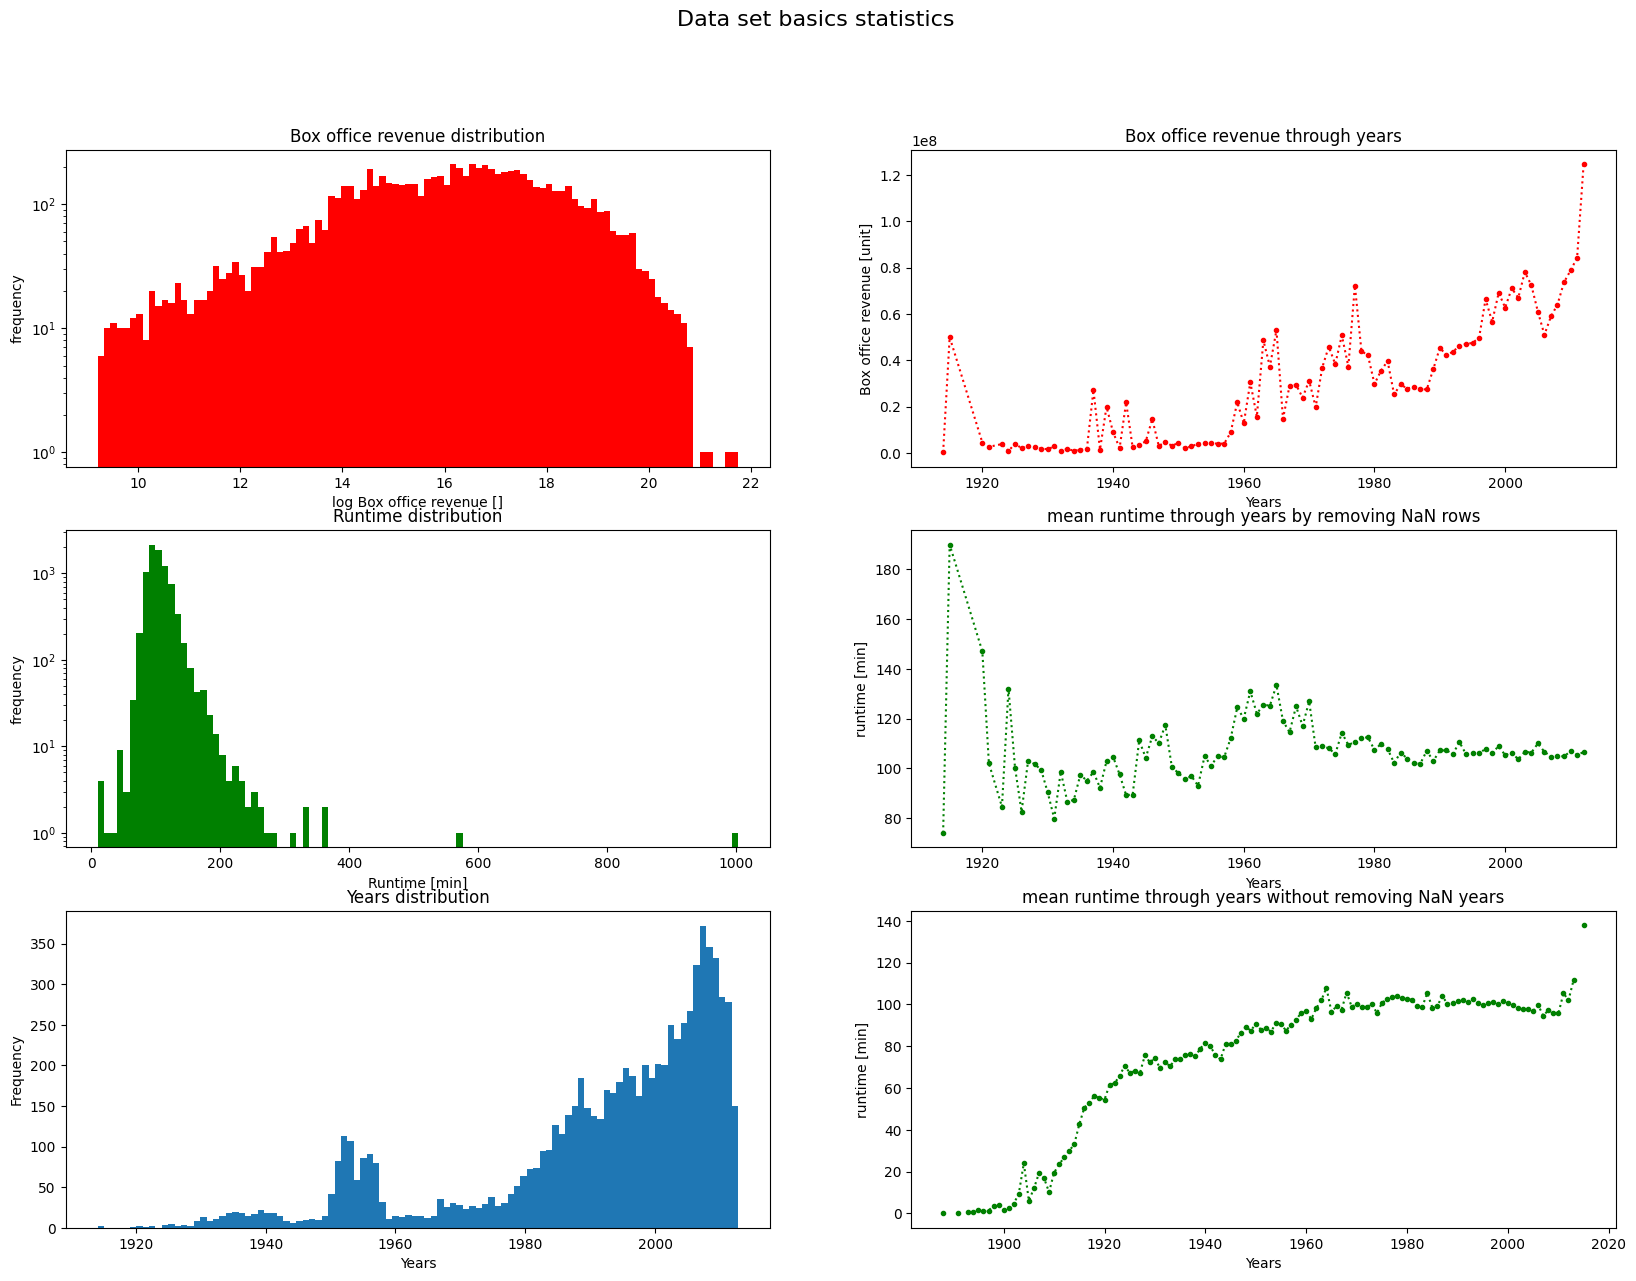

Statistics for Box office revenue: min: 10000.0, max: 2782275172.0, median: 11489643.0, mean: 49594881.88339178, std: 114107375.66550848
Statistics for Released date: min: 1914, max: 2012, median: 1997.0, mean: 1990.945641282565, std: 19.444600433323448
Statistics for Released date: min: 10.0, max: 1003.0, median: 102.0, mean: 105.82974699398797, std: 23.63320232512718


In [31]:
movies_dNA =  movies.dropna().copy()
movies_datetime = movies_dNA.groupby((pd.to_datetime(movies_dNA['Release_date']).dt.to_period('Y'))).apply(lambda x: pd.Series({
    'mean_runtime': x['Runtime'].mean(),
    'mean_box_office_revenue': x['Box_office_revenue'].mean(),
    'num_movies': len(x)
}))

def display_stats(col,name):
    print(f'Statistics for {name}: min: {np.min(col)}, max: {np.max(col)}, median: {np.nanmedian(col)}, mean: {np.mean(col)}, std: {np.std(col)}')

fig, axs = plt.subplots(3, 2)
fig.set_size_inches(20,14)
#fig.tight_layout()

axs[2,0].hist(movies_dNA.Release_date, bins = 100)
axs[2,0].set_ylabel('Frequency')
axs[2,0].set_xlabel('Years')
axs[2,0].set_title('Years distribution')

axs[0,0].hist(np.log(movies_dNA['Box_office_revenue']), bins = 100,log=True,color = 'r')
axs[0,0].set_ylabel('frequency')
axs[0,0].set_xlabel('log Box office revenue []')
axs[0,0].set_title('Box office revenue distribution')

axs[0,1].plot(movies_datetime.index.to_timestamp(),movies_datetime['mean_box_office_revenue'],'r.:')
axs[0,1].set_ylabel('Box office revenue [unit]')
axs[0,1].set_xlabel('Years')
axs[0,1].set_title('Box office revenue through years')

axs[1,1].plot(movies_datetime.index.to_timestamp(),movies_datetime['mean_runtime'],'g.:')
axs[1,1].set_ylabel('runtime [min]')
axs[1,1].set_xlabel('Years')
axs[1,1].set_title('mean runtime through years by removing NaN rows')

axs[1,0].hist(movies_dNA.Runtime, bins = 100,log=True,color = 'g')
axs[1,0].set_ylabel('frequency')
axs[1,0].set_xlabel('Runtime [min]')
axs[1,0].set_title('Runtime distribution')


movies_datetimeNA = movies.groupby((pd.to_datetime(movies['Release_date']).dt.to_period('Y'))).apply(lambda x: pd.Series({
    'mean_runtime': x['Runtime'].mean(),
    'mean_box_office_revenue': x['Box_office_revenue'].mean(),
    'num_movies': len(x)
}))
axs[2,1].plot(movies_datetimeNA.index.to_timestamp(),movies_datetimeNA['mean_runtime'],'g.:')
axs[2,1].set_ylabel('runtime [min]')
axs[2,1].set_xlabel('Years')
axs[2,1].set_title('mean runtime through years without removing NaN years')


fig.suptitle('Data set basics statistics', fontsize=16)
#fig.supxlabel('Years')
plt.show()

display_stats(movies_dNA['Box_office_revenue'],'Box office revenue')
display_stats(movies_dNA.Release_date.dt.year,'Released date')
display_stats(movies_dNA['Runtime'],'Released date')

In [32]:
print(f'By removing all rows containing NaN values, our dataset contains: {len(movies_dNA)} films')
print(f'Movie years of release span from {movies_datetime.index.min()} to {movies_datetime.index.max()}.')
y = np.array(range(1914,2012))
missing_years = y[[str(x) not in movies_datetime.index for x in y]] 
print('Our dataset does not contain films in the years', missing_years)

By removing all rows containing NaN values, our dataset contains: 7984 films
Movie years of release span from 1914 to 2012.
Our dataset does not contain films in the years [1916 1917 1918 1919 1922]


There could be a correlation between the number of movies and the box office revenue. However, with this first plot, we cannot conclude anything yet.

# ***REVOIR MARKDOWN***

In [33]:
np.mean(movies_datetime.mean_runtime)

107.08092609768111

The movie runtimes fluctuate during the first 50 years of our dataframe, overall always increasing, but then stabilized around 100 minutes from 1970 onwards. However, this shows that we will have to pay attention to the 'weights' applied to the years. Indeed during first 50 years there is a lot of variability in the mean runtime but the fact that these years contain only a few movies makes it difficult to estimate a global tendency. These underrepresented years might need to be grouped together. In comparison, the fluctuations are much less important during the last 50 years but the movie sample sizes are larger for each year, thus by law of large numbers, the means will be closer to the expected value (the reasoning is valable if we assume that the expected mean runtime is the same for each year).

#### Language and country visualizations

Text(0.5, 1.0, 'Language distribution')

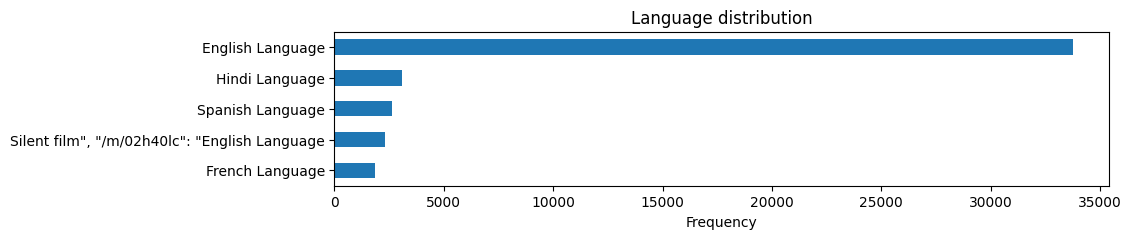

In [34]:
plt.figure(figsize=(10,2))
movies["Languages"].value_counts().sort_values().tail().plot.barh()
plt.xlabel('Frequency')
plt.title('Language distribution')

In [35]:
countries_list = []
for countries in movies_dNA['Countries']: # countries is a string of countries
    for country in countries.split(', '): # country is a single country
        if country not in countries_list:
            countries_list.append(country) # add country to the list of genres

len(countries_list)

210

Text(0.5, 1.0, 'Country distribution')

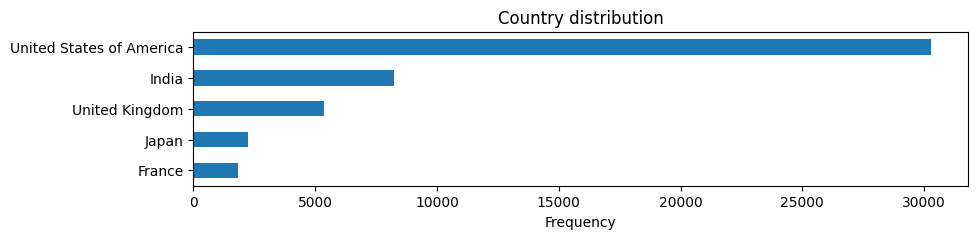

In [36]:
plt.figure(figsize=(10,2))
movies["Countries"].value_counts().sort_values().tail().plot.barh()
plt.xlabel('Frequency')
plt.title('Country distribution')

As expected, the very large majority of movies are from the USA, then most of the rest of movies can be divided into 4 main countries: India, United Kingdom, Japan and France. The other countries are underrepresented compared to these, having released very few movies. Therefore, we will now analyze the `box office revenues` of movies produced in each of these 5 prinicpal countries, since they group most of the movies.

In [37]:
short_countries_list = ['United States of America', 'India', 'United Kingdom', 'Japan', 'France']

In [38]:
for country in short_countries_list:
    movies_dNA[country] = movies_dNA['Countries'].apply(lambda x: int(x.count(country)>=1))

In [39]:
Country_Box_office_revenue = movies_dNA.groupby(pd.to_datetime(movies_dNA['Release_date']).dt.to_period(freq = 'y')).apply(lambda x:
    #All kind of analysis:
        pd.Series({
            'number': x.count(),
            'mean_US' : x[x['United States of America']>0].Box_office_revenue.mean(),
            'mean_India' : x[x['India']>0].Box_office_revenue.mean(),
            'mean_UK' : x[x['United Kingdom']>0].Box_office_revenue.mean(),
            'mean_Japan' : x[x['Japan']>0].Box_office_revenue.mean(),
            'mean_FR' : x[x['France']>0].Box_office_revenue.mean(),
        }))

Text(0.5, 1.0, 'Box office revenue time evolution by country')

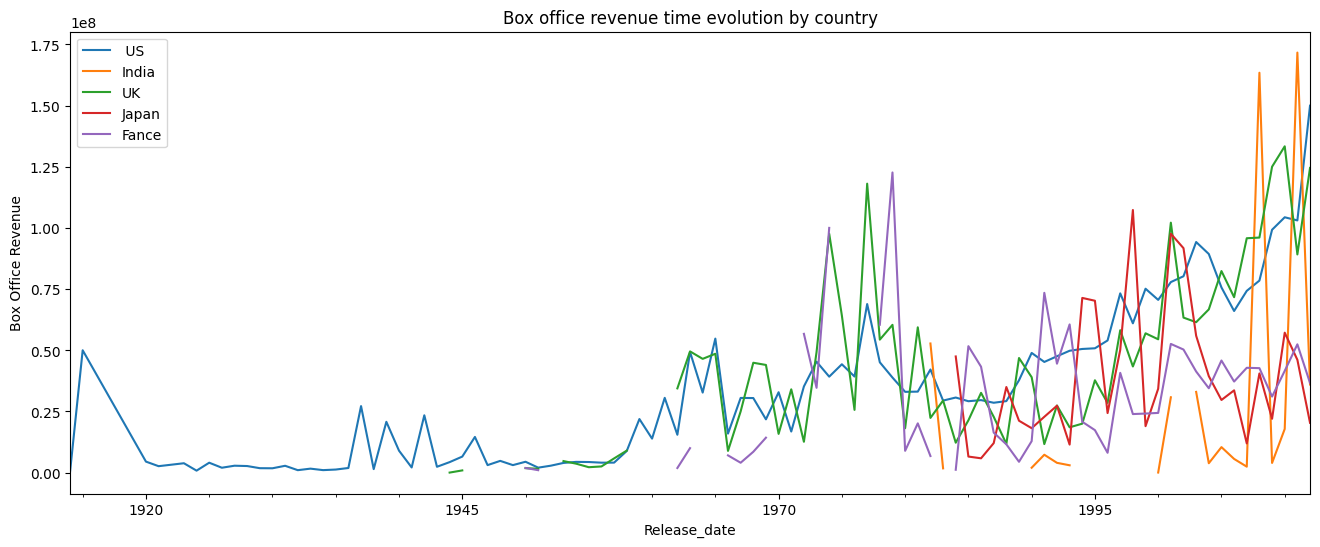

In [40]:
plt.figure(figsize=(16,6))
Country_Box_office_revenue.mean_US.plot(label=" US", legend=True)
Country_Box_office_revenue.mean_India.plot(label="India", legend=True)
Country_Box_office_revenue.mean_UK.plot(label="UK", legend=True)
Country_Box_office_revenue.mean_Japan.plot(label="Japan", legend=True)
Country_Box_office_revenue.mean_FR.plot(label="Fance", legend=True)
plt.ylabel('Box Office Revenue')
plt.title('Box office revenue time evolution by country')
#fig.suptitle('Box Office revenue', fontsize=16)

***ANALYSIS !!!!!!!!***
Expliquer les trous...

### Genre analysis

Let's start by creating a list containing all the genres present in the `movies` dataset. This will allow us to analyze the evolution of genres throughout the years and determine if ceratin historical events are associated to a given genre.

In [41]:
genre_list = []
for genres in movies_plot['Genres']: # genres is a string of genres
    for genre in genres.split(', '): # genre is a single genre
        if genre not in genre_list:
            genre_list.append(genre) # add genre to the list of genres

genre_list = [x.lower() for x in genre_list]

In [42]:
len(genre_list)

364

There are **364** different genres defined in the dataset. Some might be repetitive with each other, it might therefore be possible to group some genres together as done below using the `movies_genres` list. We can also remove the empty, film and short films from the `genre_list`, since they do not represent any concrete genre. 

In [43]:
genre_list.remove('')
genre_list.remove('film')
genre_list.remove('short film')

Now that our genres are defined, we can create a one hot encoding of the presence of a given genre in a movie. If a genre is used to define a movie it will be assigned a value of `1`, if it doesn't describe the movie it will be assigned a `0`.

In [ ]:
for genre in genre_list:
    movies_plot[genre] = movies_plot['Genres'].apply(lambda x: int(x.count(genre)>=1)) 

It can be interesting to determine which movie genre was the most realeased every decade, the popular genres might give informtion about historical events that have influenced the given trends.

In [45]:
fav_genres = movies_plot.groupby(pd.Grouper(key='Release_date',freq='10Y')).apply(lambda x: x.iloc[:,13:].sum(axis=0))
fav_genres

,adventure,supernatural,action,space western,erotic thriller,psychological thriller,drama,family film,fantasy,world cinema,...,buddy picture,journalism,statutory rape,expressionism,finance & investing,new queer cinema,neorealism,the netherlands in world war ii,revisionist fairy tale,homoeroticism
Release_date,,,,,,,,,,,,,,,,,,,,,
1893-12-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1903-12-31,1,0,0,0,0,0,2,0,4,0,...,0,0,0,0,0,0,0,0,0,0
1913-12-31,2,0,0,0,0,0,39,1,5,1,...,0,0,0,0,0,0,0,0,0,0
1923-12-31,33,1,10,0,0,0,177,17,16,15,...,0,0,0,1,0,0,0,0,0,0
1933-12-31,110,0,82,0,0,6,550,78,25,32,...,0,0,0,1,0,0,0,0,0,0
1943-12-31,288,5,244,0,0,18,839,261,46,30,...,0,0,0,0,0,0,1,0,0,0
1953-12-31,303,4,257,0,0,69,1064,245,75,78,...,0,0,0,0,0,0,0,0,0,0
1963-12-31,396,13,332,0,0,41,1310,228,84,272,...,0,0,0,0,0,0,0,0,0,0
1973-12-31,560,38,534,1,7,75,1401,159,109,438,...,0,0,0,0,0,1,0,0,0,0


In [46]:
maxGenre = fav_genres.max(axis=1)
maxGenre_id = fav_genres.idxmax(axis=1)
maxGenre_id

Release_date
1893-12-31              indie
1903-12-31        silent film
1913-12-31        silent film
1923-12-31        silent film
1933-12-31    black-and-white
1943-12-31    black-and-white
1953-12-31              drama
1963-12-31              drama
1973-12-31              drama
1983-12-31              drama
1993-12-31              drama
2003-12-31              drama
2013-12-31              drama
2023-12-31              drama
dtype: object

From the output above, in the 1890s the most prevalent genre was `indie`. Indie movies are short films produced outside the major filming studios and by independent entertainment companies, therefore their presence in the 1890s marks the begining of film making, when the very first short movies were created. Then, between the 1900s and 1920s, `silent movies` were produced in majority. This also illustrates the film making historical timeline, [Warner Bros](https://www.moma.org/learn/moma_learning/themes/film/experimentation-with-sound/#:~:text=On%20October%206%2C%201927%2C%20Warner,was%20a%20revelation%20for%20audiences.) were the first to syncronise sound recordings to movies in 1927, from this point onwards sound was widely used in movies. Between the 1930s and the 1940s the most released genre was `black-and-white`, which is understandable given that color motion picture films were introduced around 1940 but only came to wide use in 1950, as explained by this ["Wikipedia"](https://en.wikipedia.org/wiki/Color_motion_picture_film#:~:text=They%20were%20introduced%20around%201940,production%20in%20the%20early%201950s.) article. However, from the 1940s onwards, `drama` is the most popular genre produced, which might reflect the general public's preference, since movies were much more accessible to all from the 1950s onwards due to the television's arrival on the market. The television first, then home videos and later on internet strongly influenced the distribution and consumption of films, as more people watched movies, more movies were made to please the public, which might explain why drama movies were made abundantly.

In [47]:
indie_movies = time_analysis('indie', 0, freq='2y')
silent_movies = time_analysis('silent film', 0, freq='2y')
bw_movies = time_analysis('black-and-white', 0, freq='2y')
drama_movies = time_analysis('drama', 0, freq='2y')

Let's look at the evolution of the presence of these genres with time.

Text(0, 0.5, 'Number of movies (drama scale)')

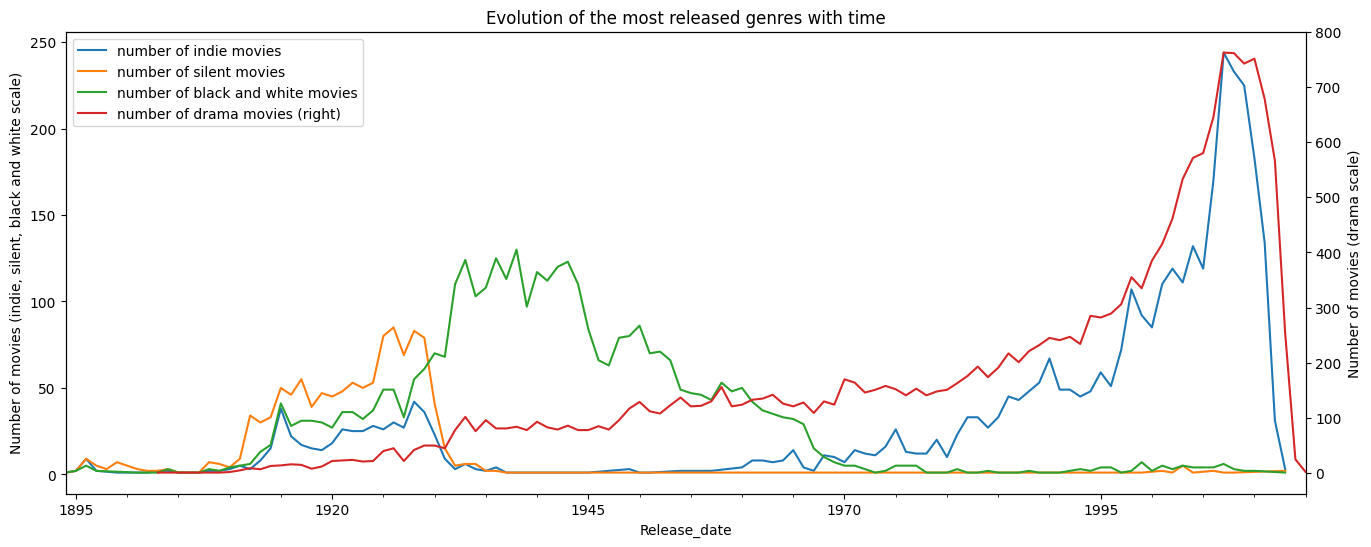

In [48]:
plt.figure(figsize = (16,6))
indie_movies.number.plot(label="number of indie movies", legend=True)
silent_movies.number.plot(label="number of silent movies", legend=True)
bw_movies.number.plot(label="number of black and white movies", legend=True)
plt.ylabel('Number of movies (indie, silent, black and white scale)')
drama_movies.number.plot(secondary_y=True, label="number of drama movies", legend=True)
plt.title('Evolution of the most released genres with time')
plt.ylabel('Number of movies (drama scale)')

The evolution of the number of movies of each genre described above highlights the historical events representing major technological milestones for film making. We can see peaks in each curve that follow each other in chronological order: first a peak in indie and silent movies appear, followed by a peak in black-and-white movies and several years later a very strong increase in drama movies. Indie movies also underwent a significant increase after the 1990s, but this is probably due to stong growth of the movie industry and its productivity overall. 

# STEP 2: Historical dictionnary definitions and applications

Trick: could add spaces in front of words that are ambiguous. Example below with SS: a lot of words contain the sequence ss, but space+ss is rare. We could even consider space+ss++space, but this would exclude some occurances due to punctuation.

### World War I

In [49]:
WW1 =  ['WW1', 'World War 1', '1914', '1918', 'Allies', 'armistice', 'Central Powers', 'conscription', 'front line', 'Joffre', 'Kaiser', 'Marne',
        'mustard gas', 'no man’s land', 'Pétain', 'u boats', 'Somme', 'Treaty of Versailles', 'trench', 'Verdun', 'Western front', 
        'zeppelin', 'artillery', 'doughboy', 'duckboards', 'dreadnought', 'mobilize', 'Prussia', 'Schlieffen plan', 'Tsar', 'Archduke Ferdinand',
        'Red Baron', 'big four', 'Christmas truce', 'Wilson', 'Lusitania', 'Battalion', 'triple entente', 'Great War', 'flamethrower', 'mills bomb',
        'storm troop', 'ace', 'recco', 'tailspin', 'boche', 'wipers', 'kiwi', 'Aussie', 'cootie', 'Flanders', 'mud', 'war effort', 
        'League of Nations']
WW1 = [x.lower() for x in WW1]

### World War II

In [50]:
WW2 =  ['Allies','Auschwitz','Bombardment', 'battleship', 'Bailey bridge', 'Blitzkrieg','Churchill','D-Day',' ss'
        'Dunkirk', 'Doolittle', 'de Gaulle','English Channel', 'Eisenhower','Enigma','flying tigers', 'free french',
        'nazi','helmet','Hiroshima','Invasion','Luftwaffe','Manhattan Project', 'Midway','Pearl harbor','Normandy', 'Nagasaki',
        'Panzer','Roosevelt', 'Rangers','Resistance','Truman', 'Stalin', 'tank','Victory', 'V-1 rocket','doodlebugs',
        'World War II','ww2','Hitler','air raid','shelter','siren','Battle of Britain','evacuee','evacuation','gas mask',
        'spitfire', '1939', '1945']
WW2 = [x.lower() for x in WW2]

### Space race

In [51]:
Space = ['aeronautics','Alan Shepard','Apollo','Cape Canaveral','capitalism','Cold War','Communism','Gemini','heat shields', 
         'Houston','John Glenn','Laika','launch','Lunar Module','Mercury','Michael Collins','Mission Control','NASA','neil Armstrong',
         'orbit','planet','rocket','satellite','Scott Carpenter','Sergei Korolev','solar system','space','space exploration','Space Race',
         'Sputnik','superpowers','test pilot',' USA',' URSS','Yuri Gagarin']
Space = [x.lower() for x in Space]

### Technological revolution

In [52]:
Tech = ['Application', 'Bandwidth','Blog', 'Browser', 'Bugs', 'Bytes',' CAD', ' CAM','Camera', ' CD', 'phone',' Codes', ' Computer',' Copyright', ' Cyberspace',
        ' Data',' Database',' Debug',' Digital', ' Disk',' Display', ' Download',' Drive', ' car',' E-mail', 'Electronic',' Electronics','Bio-tech',' Ethernet'
        ,'FaceBook',' Fax',' Fiber optic',' File',' Geek',' GIF',' net',' Hackers',' Hard disk',' Hard drive',' Hardware', ' Hypertext', ' Informatics', ' Innovation',
        ' Internet',' IPAD',' Joystick',' JPEG',' mail',  'Keyboard','Keypad',' Laptop',' Laser',' robot','Matrix', ' Networks', 
        ' Operating system',' Printer',' Processor',' Program',' Programmer',' Protocol',' Radio',' Satellite',' Scan',' Screen',' Script',' Search engine',
        ' Share','Software',' Spam', 'Statistics',' Technology',' Telecommunication',' Television', 'google','youtube','yahoo','connector',' Upload',' Username',' User-friendly',
        ' Video',' Virus',' Web',' Wireless', ' www','Worldwide web',' weapons',' plane']
Tech = [x.lower() for x in Tech]

### Racial segregation

In [53]:
Segregation = ['Racial', 'ethnic groups', 'apartheid', 'Nelson Mandela', 'racial discrimination', 'Jim Crow laws', 'white supremacy', 
               'interracial marriage', 'Rosa Parks', 'Martin Luther King Jr', 'Civil rights', 'Negro', 'discrimination']
Segregation = [x.lower() for x in Segregation]

### LGBTQ+ emancipation

In [54]:
LGBT = ['Lesbian', 'gay', 'Bisexual', 'transgender', 'gender identity', 'non-cisgender', 'queer', 'Gender variance', 'homosexuality', 
        'Gay liberation', 'Stereotype', 'AIDS stigma', 'feminism', 'gay rights', 'Daughters of Bilitis', 'patriarchal', 'marginalize', ]
LGBT = [x.lower() for x in LGBT]

### Dictionnary applications and metrics

For consistency, we will apply a lower case every plot summary:

In [55]:
summaries = movies_plot.Summary.apply(lambda h: h.lower())

We can create a first feature containing the count of the number of times a word from a given dictionnary appears in a plot summary. This function creates a new column in the movies_plot DF.

In [56]:
def count_dict(name, dictionnary):
    movies_plot[name] = summaries.apply(lambda summary: np.sum([summary.count(word) for word in dictionnary]))
                                          

In [57]:
count_dict('WW1', WW1)
count_dict('WW2', WW2)
count_dict('SpaceRace', Space)
count_dict('Tech', Tech)
count_dict('Segregation', Segregation)
count_dict('LGBT', LGBT)

In [58]:
movies_plot.head(1)

,Wikipedia_movie_ID,Freebase_movie_ID,Name,Release_date,Box_office_revenue,Runtime,Languages,Countries,Genres,Summary,...,neorealism,the netherlands in world war ii,revisionist fairy tale,homoeroticism,WW1,WW2,SpaceRace,Tech,Segregation,LGBT
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,"thriller, science fiction, horror, adventure, ...","Set in the second half of the 22nd century, th...",...,0,0,0,0,1,0,1,1,0,0


### Metric

If we do number of words, it could depend too much on the length of the plot summary or the length and quality of the dictionnary. Thus, a min-max scaling or standardization could be usefull afterward in the feature space. _> def % nbre mots ?

In [59]:
#temporary thresholds:
ww1T = 15
ww2T = 5
SpaceT = 5
techT = 30
segT = 5
lgbtT = 5

### WordCount Plots

To get a first sense of if the dictionnaries implemented previously accurately sort the `movies_plot` dataset into their respective historical periods or events, we will use a data visualization technique used for representing the frequency of words in text data: `WordCloud` plots. Word clouds highlight significant textual data points through plots in which the size of each word indicates its frequency or importance. We will therefore create WordCloud plots of the summaries of the movies that were historically sorted using the dictionnaries defining events. This will allow us to determine if the most frequent words in the summaries match the words that build the respective dictionnaries used.

In [60]:
# First separate the movies by historical event
WW1 = movies_plot[movies_plot['WW1'] > ww1T]['Summary']
WW2 = movies_plot[movies_plot['WW2'] > ww2T]['Summary']
Space = movies_plot[movies_plot['SpaceRace'] > SpaceT]['Summary']
Tech = movies_plot[movies_plot['Tech'] > techT]['Summary']
Segregation = movies_plot[movies_plot['Segregation'] > segT]['Summary']
LGBT = movies_plot[movies_plot['LGBT'] > lgbtT]['Summary']

In [61]:
# Check for null values since WordCount doesn't accept text with NAN
print(WW1.isna().sum())
print(WW2.isna().sum())
print(Space.isna().sum())
print(Tech.isna().sum())
print(Segregation.isna().sum())
print(LGBT.isna().sum())

0
0
0
0
0
0


In [62]:
w = WordCloud()
stop_words = list(w.stopwords) # remove usual stop words (frequently used)
custom_stop_words = ['find', 'back', 'one', 'will', 'take'] # remove other meaningless frequent words
stop_words = set(stop_words + custom_stop_words)

In [63]:
# WordCloud only accepts strings
summary_WW1 = " ".join(title for title in WW1)
summary_WW2 = " ".join(title for title in WW2)
summary_Space = " ".join(title for title in Space)
summary_Tech = " ".join(title for title in Tech)
summary_Segregation = " ".join(title for title in Segregation)
summary_LGBT = " ".join(title for title in LGBT)

In [64]:
# Generate word clouds
wordcloud_WW1 = WordCloud(collocations = False, background_color = 'white', stopwords=stop_words).generate(summary_WW1)
wordcloud_WW2 = WordCloud(collocations = False, background_color = 'white', stopwords=stop_words).generate(summary_WW2)
wordcloud_Space = WordCloud(collocations = False, background_color = 'white', stopwords=stop_words).generate(summary_Space)
wordcloud_Tech = WordCloud(collocations = False, background_color = 'white', stopwords=stop_words).generate(summary_Tech)
wordcloud_Segregation = WordCloud(collocations = False, background_color = 'white', stopwords=stop_words).generate(summary_Segregation)
wordcloud_LGBT = WordCloud(collocations = False, background_color = 'white', stopwords=stop_words).generate(summary_LGBT)

(-0.5, 399.5, 199.5, -0.5)

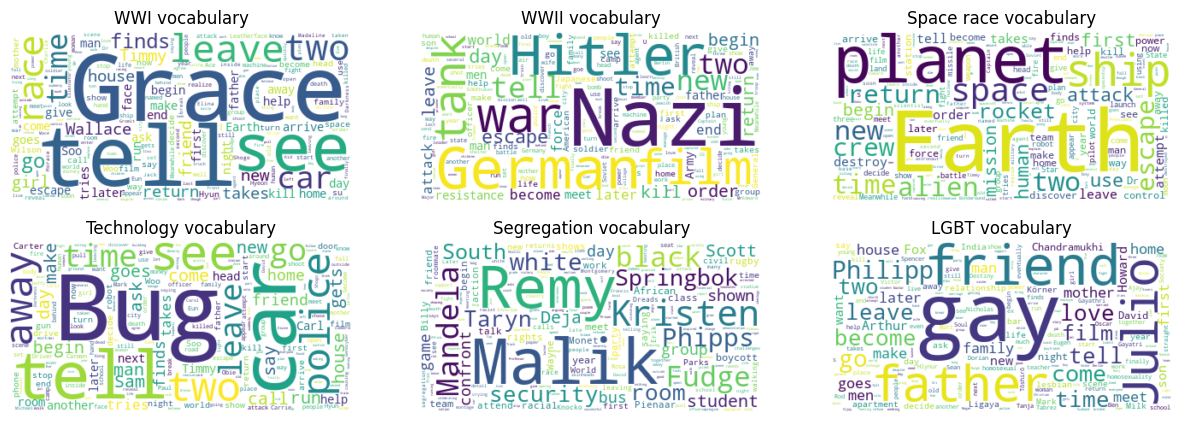

In [65]:
# Plot word clouds

fig, axs = plt.subplots(2, 3, figsize=(15,5))

axs[0,0].imshow(wordcloud_WW1, interpolation="bilinear")
axs[0,0].set_title("WWI vocabulary")
axs[0,0].axis('off')

axs[0,1].imshow(wordcloud_WW2, interpolation="bilinear")
axs[0,1].set_title("WWII vocabulary")
axs[0,1].axis('off')

axs[0,2].imshow(wordcloud_Space, interpolation="bilinear")
axs[0,2].set_title("Space race vocabulary")
axs[0,2].axis('off')

axs[1,0].imshow(wordcloud_Tech, interpolation="bilinear")
axs[1,0].set_title("Technology vocabulary")
axs[1,0].axis('off')

axs[1,1].imshow(wordcloud_Segregation, interpolation="bilinear")
axs[1,1].set_title("Segregation vocabulary")
axs[1,1].axis('off')

axs[1,2].imshow(wordcloud_LGBT, interpolation="bilinear")
axs[1,2].set_title("LGBT vocabulary")
axs[1,2].axis('off')


The word clouds above show very promising results. A part from the `WWI` movie dataframe, all the other movies show frequent words explicitely relating to the historical period they were assigned to. For example, in the `WWII` word cloud, the word **german** appears frequently in the movie summaries even though it was not used to build the WWII dictionnary. This is also the case for the word **Earth** or **alien** in the `SpaceRace` movie dataframe. The example is also found in the `Segregation` and `LGBT` dataframes, which respectively see the words **black** and **friend** appear in the word cloud plots but not in their dictionnaries.

# STEP 3: Examples of historical event characterisations


### Which genres are used to convey a historical event ?

We can now analyze genre appearance for our historical periods and the evolution of the number of movies narrating the historical events with time.

In [66]:
movies_genres = ['Action', 'Adventure', 'Comedy', 'Fantasy', 'Historical', 'Horror', 'Satire', 'Science finction', 'Speculative',
                 'Thriller', 'Western', 'Drama', 'Horror', 'Documentary', 'Musical', 'Romance','Mystery', 'War', 'Biography', 'History',
                 'zombie film', 'Alien', 'Musical', 'anti-war', 'Black-and-white', 'Cold war', 'combat', 'Conspiration', 'crime', 
                'Documentary', 'Erotic', 'Gay', 'LGBT', 'Political', 'Romantic', 'sci-fi', 'sci fi', 'children']
movies_genres = [x.lower() for x in movies_genres]

In [67]:
for genre in movies_genres:
    movies_plot[genre] = movies_plot['Genres'].apply(lambda x: int(x.count(genre)>=1)) 

In [68]:
dictionnary_genres = pd.DataFrame()
dictionnary_genres['WW1'] = movies_plot[movies_plot['WW1'] > ww1T][movies_genres].sum()
dictionnary_genres['WW2'] = movies_plot[movies_plot['WW2'] > ww2T][movies_genres].sum()
dictionnary_genres['SpaceRace'] = movies_plot[movies_plot['SpaceRace'] > SpaceT][movies_genres].sum()
dictionnary_genres['Tech'] = movies_plot[movies_plot['Tech'] > techT][movies_genres].sum()
dictionnary_genres['Segregation'] = movies_plot[movies_plot['Segregation'] > segT][movies_genres].sum()
dictionnary_genres['LGBT'] = movies_plot[movies_plot['SpaceRace'] > lgbtT][movies_genres].sum()

dictionnary_genres.head()

,WW1,WW2,SpaceRace,Tech,Segregation,LGBT
action,32,75,135,16,0,135
adventure,25,64,176,14,0,176
comedy,30,36,74,35,0,74
fantasy,14,11,51,4,0,51
historical,2,8,1,0,0,1


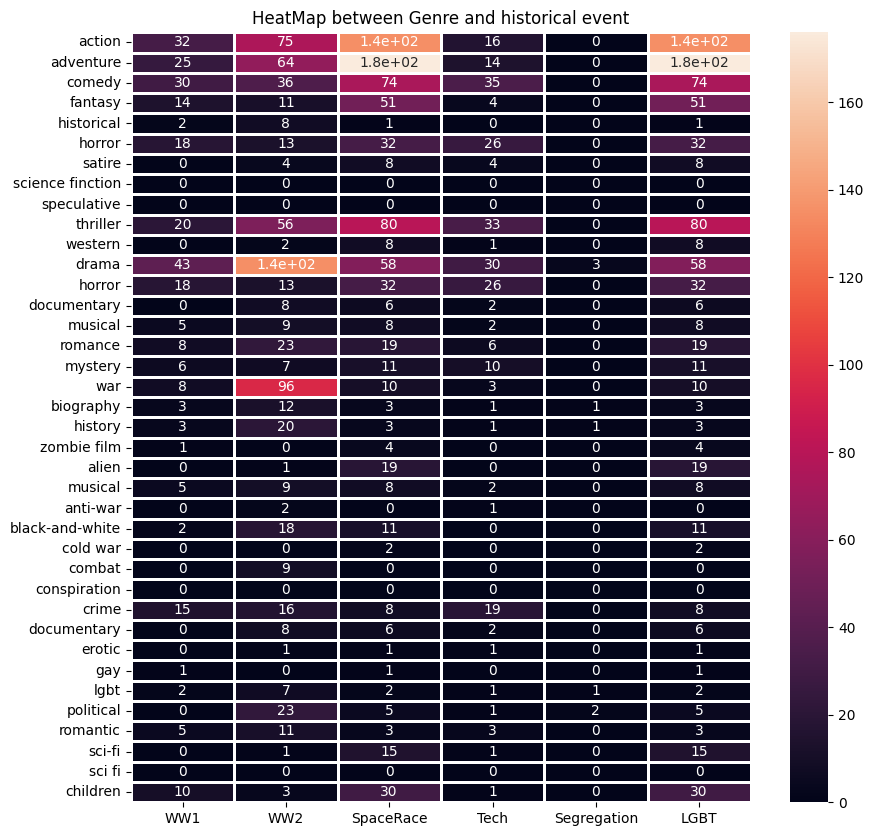

In [69]:
plt.figure(figsize=(10,10))
heat_map = sns.heatmap( dictionnary_genres, linewidth = 1 , annot = True)
plt.title( "HeatMap between Genre and historical event" )
plt.show()

### Color code per historical event for plots:

In [140]:
color_map = dict([
    ('WW1',['r']),
    ('WW2',['g']),
    ('SpaceRace',['b']),
    ('Tech',['k']),
    ('Segregation',['m']),
    ('LGBTQ',['y'])
])

### Evolution of the number of movies representing a historical period with time 

In [141]:
WW1_analysis = time_analysis('WW1',thr= 0, freq='2y')
WW2_analysis = time_analysis('WW2', thr=0, freq='2y')
SpaceRace_analysis = time_analysis('SpaceRace',thr= 0, freq='2y')
Tech_analysis = time_analysis('Tech',thr= 0, freq='2y')
Segregation_analysis = time_analysis('Segregation', thr=0, freq='2y')
lgbt_analysis = time_analysis('LGBT', thr=0, freq='2y')

Text(0, 0.5, 'Frequency (WW1 and tech)')

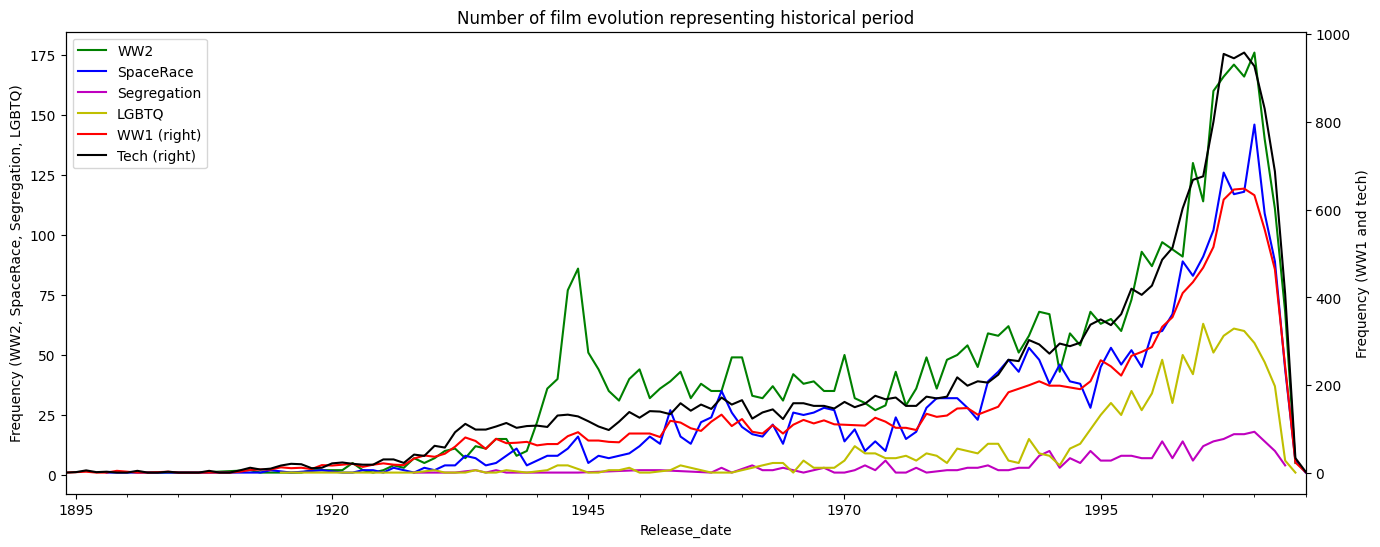

In [142]:
plt.figure(figsize = (16,6))

WW2_analysis.number.plot(label="WW2", legend=True,color = color_map["WW2"]) # secondary_y=True
SpaceRace_analysis.number.plot(label="SpaceRace", legend=True,color = color_map["SpaceRace"])
plt.ylabel('Frequency (WW2, SpaceRace, Segregation, LGBTQ)')
Segregation_analysis.number.plot(label="Segregation", legend=True,color = color_map["Segregation"])
lgbt_analysis.number.plot(label="LGBTQ", legend=True,color = color_map["LGBTQ"])
plt.title('Number of film evolution representing historical period')
WW1_analysis.number.plot(secondary_y=True, label="WW1", legend=True,color = color_map["WW1"])
Tech_analysis.number.plot(secondary_y=True, label="Tech", legend=True,color = color_map["Tech"])
plt.ylabel('Frequency (WW1 and tech)')

Let's analyze these curve individually to better capture small fluctuations.

Text(0.02, 0.5, 'Number of movies')

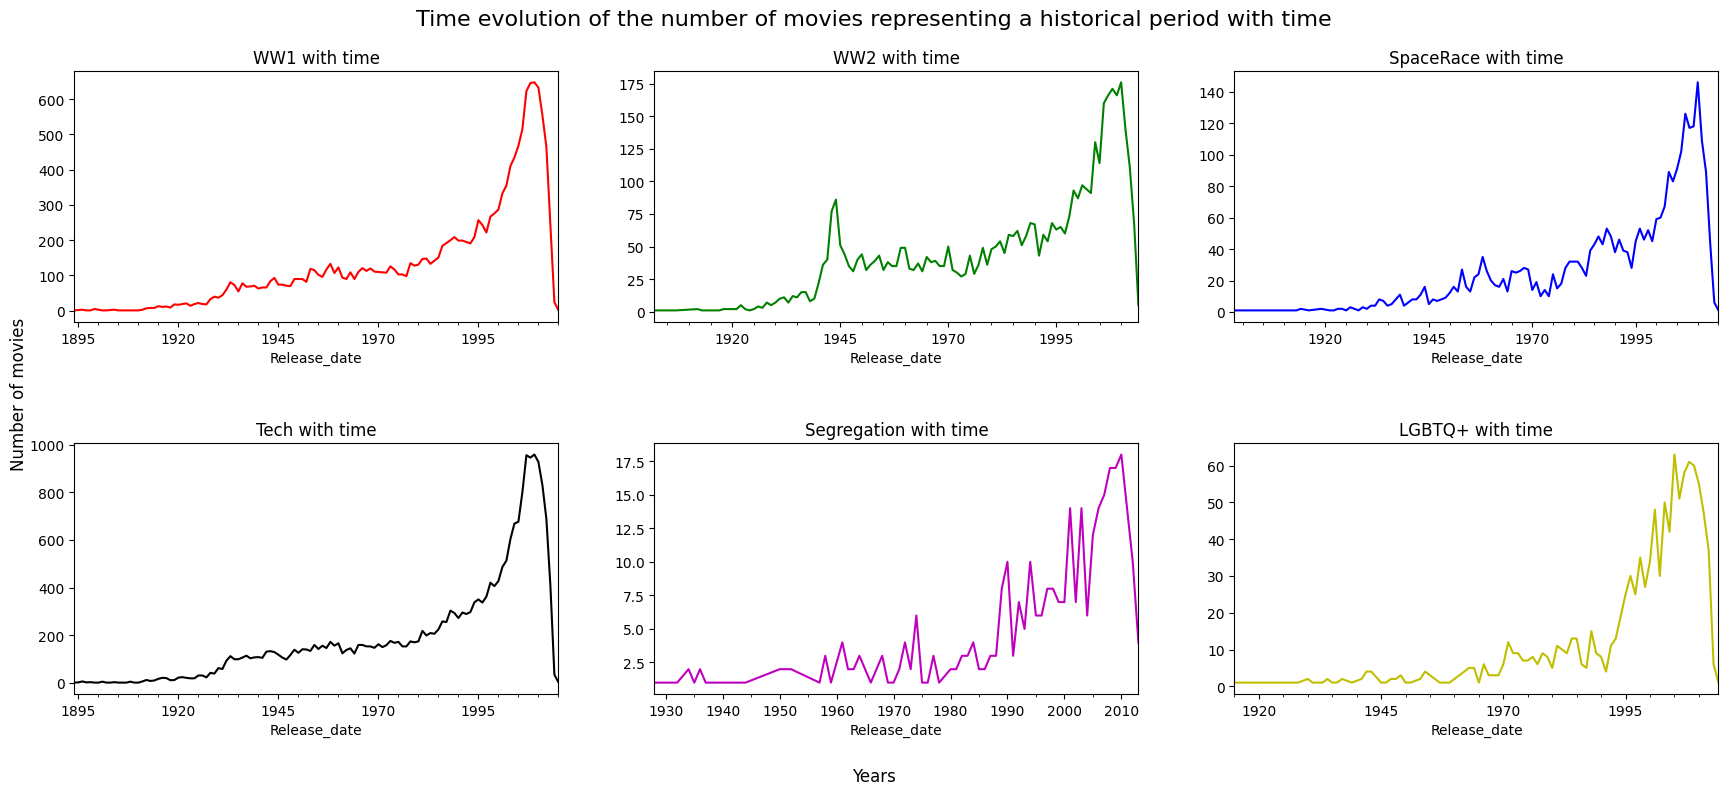

In [143]:
fig, axs = plt.subplots(2, 3, figsize=(18,8))

WW1_analysis.number.plot(ax=axs[0,0], label="WW1", title="WW1 with time",color = color_map['WW1'])
WW2_analysis.number.plot(ax=axs[0,1], label="WW2", title="WW2 with time",color = color_map['WW2']) # secondary_y=True
SpaceRace_analysis.number.plot(ax=axs[0,2], label="SpaceRace", title="SpaceRace with time",color = color_map['SpaceRace'])
Tech_analysis.number.plot(ax=axs[1,0], label="Tech", title="Tech with time",color = color_map['Tech'])
Segregation_analysis.number.plot(ax=axs[1,1], label="Segregation", title="Segregation with time",color = color_map['Segregation'])
lgbt_analysis.number.plot(ax=axs[1,2], label="LGBTQ", title="LGBTQ+ with time",color = color_map['LGBTQ'])

plt.tight_layout(pad=4)
fig.suptitle('Time evolution of the number of movies representing a historical period with time', fontsize=16)
fig.supxlabel('Years')
fig.supylabel('Number of movies')



### Evolution of the box office revenue of movies representing a historical period with time 

In [74]:
def plot_distr(name,thr,xname,yname,glm=LinearRegression(),logy=False,axis=plt,color = 'r'):
    """        
    Parameters
    ----------
    name : name of the historical event
    thr : threshold for accepting the movie as portraying the event
    xname : name of the column we want on x axis
    yname : name of the column we want on y axis
    glm : glm method to use (https://scikit-learn.org/0.15/modules/linear_model.html)
    logy : True if we want the y axis in log scale
    axis : axis to plot on, default : plt for single figure
        
    Returns
    -------
    Plots the two features selcted relative to each other and their linear regression.
    """

    time_dist = movies_plot[movies_plot[name] > thr].copy()
    if xname=='Release_date' or yname=='Release_date' :
        pd.options.mode.chained_assignment = None  # default='warn' # get rid of warnings
        time_dist['Release_date'] = pd.to_datetime(time_dist['Release_date']).dt.year
        pd.options.mode.chained_assignment = 'warn'  # default='warn' # put warnings back
    time_dist = time_dist.dropna()
    Y = time_dist[yname]
    if logy : 
        Y = Y.apply(lambda x : np.log(x))
        yname = 'log '+ yname
    X = np.array(time_dist[xname]).reshape(-1, 1)
    
    axis.plot(time_dist[xname],Y,f'{color}.',label = f'{name} movie')
    
    
    reg = glm.fit(X,Y)
    t = np.array(np.linspace(time_dist[xname].min(),time_dist[xname].max(),1000)).reshape(-1,1)
    axis.plot(t,reg.predict(t),'-',label = str(glm))
    
    if axis == plt : #use Axes syntax
        axis.legend()
        axis.xlabel(xname)
        axis.ylabel(yname)
        axis.title(f'{yname} distribution for {name} event')
    else : #use Axes.subplots syntax
        axis.legend()
        axis.set_xlabel(xname)
        axis.set_ylabel(yname)
        axis.set_title(f'{yname} distribution for {name} event')

    return 

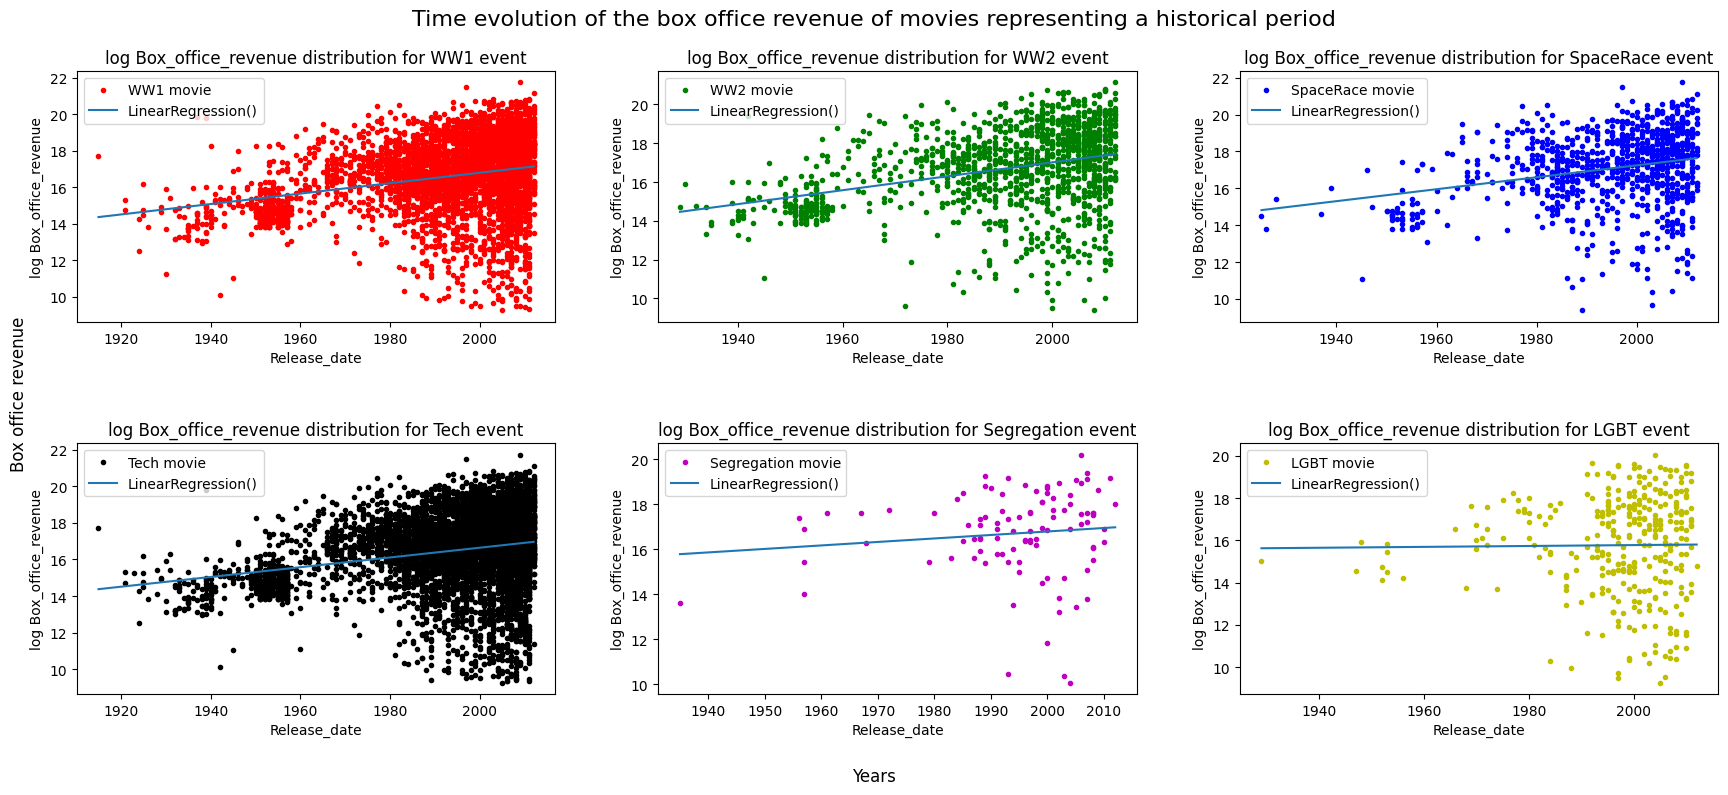

In [144]:
fig, ax = plt.subplots(2, 3, figsize=(18,8))

plot_distr('WW1',0,'Release_date','Box_office_revenue',logy=True,axis=ax[0,0],color = color_map['WW1'][0])
plot_distr('WW2',0,'Release_date','Box_office_revenue',logy=True,axis=ax[0,1], color = color_map['WW2'][0])
plot_distr('SpaceRace',0,'Release_date','Box_office_revenue',logy=True,axis=ax[0,2], color = color_map['SpaceRace'][0] )
plot_distr('Tech',0,'Release_date','Box_office_revenue',logy=True,axis=ax[1,0], color = color_map['Tech'][0])
plot_distr('Segregation',0,'Release_date','Box_office_revenue',logy=True,axis=ax[1,1], color = color_map['Segregation'][0])
plot_distr('LGBT',0,'Release_date','Box_office_revenue',logy=True,axis=ax[1,2],color = color_map['LGBTQ'][0])


plt.tight_layout(pad=4)
fig.suptitle('Time evolution of the box office revenue of movies representing a historical period', fontsize=16)
fig.supxlabel('Years')
fig.supylabel('Box office revenue')
plt.show()



In [80]:
movies_plot[movies_plot['Segregation'] > 5]
#Segregation_analysis

,Wikipedia_movie_ID,Freebase_movie_ID,Name,Release_date,Box_office_revenue,Runtime,Languages,Countries,Genres,Summary,...,war,alien,combat,conspiration,erotic,political,romantic,sci-fi,sci fi,children
11627,3306822,/m/094nfs,The Rosa Parks Story,2002-02-10,NaN,97.0,English Language,United States of America,"biographical film, drama, political drama",This is an account of the life of Rosa Parks a...,...,0,0,0,0,0,1,0,0,0,0
19296,21939688,/m/07yk1xz,Invictus,2009-12-03,122233971.0,135.0,"Afrikaans Language"", ""/m/0dds9"": ""M\u0101ori l...","United States of America"", ""/m/0hzlz"": ""South ...","biography, history, film adaptation, sports, d...","On 2 February, 1990, Nelson Mandela is release...",...,0,0,0,0,0,1,0,0,0,0
27791,695435,/m/033gkt,Higher Learning,1995-01-11,38000000.0,128.0,English Language,United States of America,"lgbt, ensemble film, drama","We first see Malik Williams , Kristen Connor ,...",...,0,0,0,0,0,0,0,0,0,0


## PCA 

Let's define the features we will use in the PCA and that we will normalize. We could define more features by introducing character information i.e. gender ratio, age, height etc.. just need computation and fusion of DF.

In [109]:
features = ['Box_office_revenue','WW1','WW2','SpaceRace','Tech','LGBT','Segregation']
PCAfeature = movies_plot[features].dropna()
PCAfeature= preprocessing.StandardScaler().fit(PCAfeature).transform(PCAfeature) #standardize
print(np.mean(PCAfeature,axis = 0),np.std(PCAfeature,axis = 0))

color_map = dict([
    ('WW1',['r']),
    ('WW2',['g']),
    ('SpaceRace',['b']),
    ('Tech',['k']),
    ('Segregation',['m']),
    ('LGBT',['y']),
    ('Box_office_revenue',['c'])
])

[ 2.66910083e-17 -1.75598739e-18 -3.27784312e-17  1.31113725e-17
 -3.27784312e-17  4.77628569e-17  1.31113725e-17] [1. 1. 1. 1. 1. 1. 1.]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


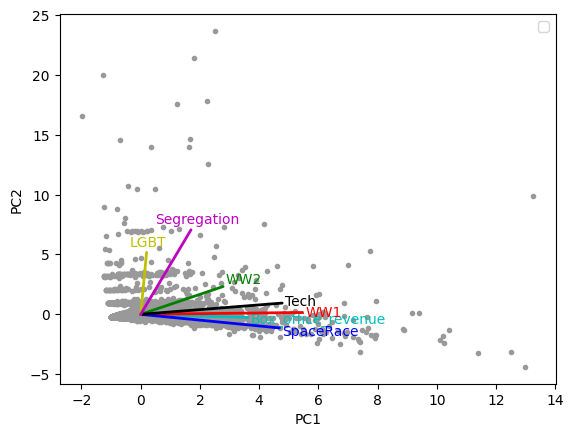

In [135]:
pca = PCA(2)  
projected = pca.fit_transform(PCAfeature)


ax = plt.gca()

for i,f in enumerate(features):
    c = color_map[f][0]
    ax.annotate(f,[0,0],10*pca.components_[:,i],arrowprops= dict(arrowstyle='-',linewidth=2,shrinkA=0,shrinkB=0, color = c),color= c)
    
plt.plot(projected[:, 0], projected[:, 1],'.',color = '0.6')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

## Kmean analysis

The same question is asked here, which features should we choose... For now, we will choose the same ones as in the PCA section.

In [225]:
K = 6
kmeans = KMeans(n_clusters=K, random_state=1).fit(PCAfeature)
kmeans.labels_

array([1, 1, 1, ..., 1, 1, 1])

We will plot the Kmean onto the 2 first PC

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


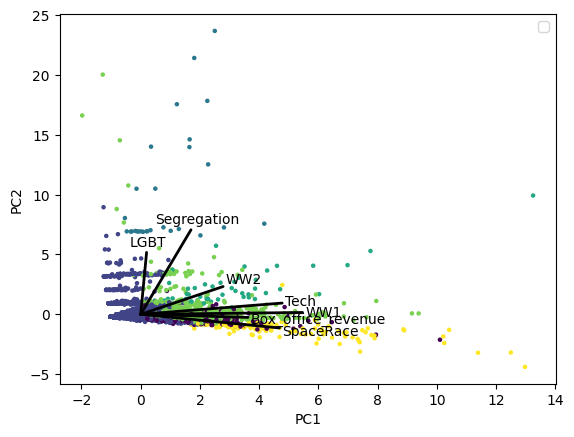

In [133]:
ax = plt.gca()
arrowprops = dict(arrowstyle='-',linewidth=2,shrinkA=0,shrinkB=0)

for i,f in enumerate(features):
    c = color_map[f][0]
    ax.annotate(f,[0,0],10*pca.components_[:,i],arrowprops= arrowprops,color= 'k')
    
plt.scatter(projected[:, 0], projected[:, 1],c = kmeans.labels_,s= 5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# TOUT CE QUI EST EN DESSOUS JE N'AI PAS CLEAN

# **STEP 2: Analysis (Old version !!!)** Ne sais pas trop quoi faire

je sais pas si c'est plus parlant comme graph?

## Movie Genres analysis -> FAIT PLUS HAUT MAIS GARDE SI JAMAIS 

In [67]:
erotique_analysis = time_analysis('erotic', 0, freq='2y')
gay_analysis = time_analysis('gay', 0, freq='2y')
lgbt_analysis = time_analysis('lgbt', 0, freq='2y')
WW1_analysis = time_analysis('WW1', 0, freq='2y')
SpaceRace_analysis = time_analysis('SpaceRace', 0, freq='2y')

<AxesSubplot:>

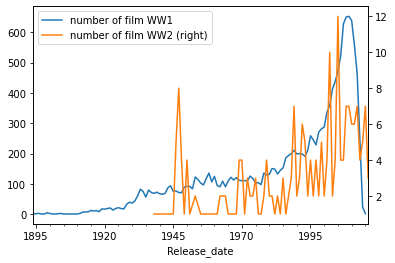

In [68]:
WW1_analysis.number.plot(grid=True, label="number of film WW1", legend=True)
WW2_analysis.number.plot(secondary_y=True, label="number of film WW2", legend=True)

<AxesSubplot:xlabel='Release_date'>

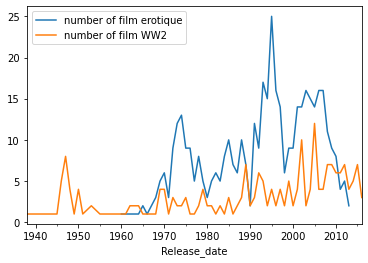

In [69]:
erotique_analysis.number.plot(grid=True, label="number of film erotique", legend=True)
WW2_analysis.number.plot(label="number of film WW2", legend=True)

<AxesSubplot:xlabel='Release_date'>

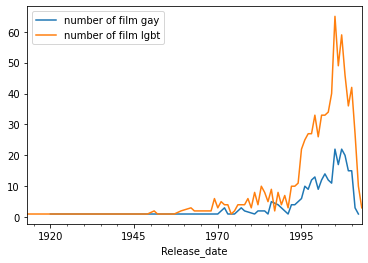

In [70]:
gay_analysis.number.plot(label="number of film gay", legend=True)
lgbt_analysis.number.plot(label="number of film lgbt", legend=True)

<AxesSubplot:xlabel='Release_date'>

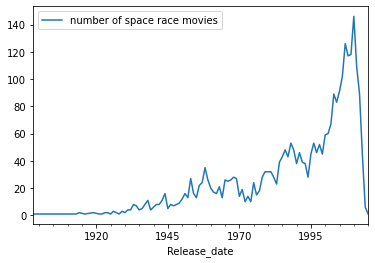

In [71]:
SpaceRace_analysis.number.plot(label="number of space race movies", legend=True)